## Pertubation of the apex edge-created domains

In [2]:
# Enable detailed CUDA error reporting
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from src.loader import load_graph
from classes import extract_all_features_single 
import sys
import os
from src import utils
import numpy as np
import pandas as pd
import torch
import torch_geometric.transforms as T
from src.utils import largest_indices
from src.utils import cal_n_add_facni 
from src.utils import extract_feat_adj2
from src.utils import calc_cad 
import networkx as nx
from scipy import spatial
import copy  
from matplotlib import pyplot as plt 
import random

# Routines

In [3]:
def confid_measures(arr_tri, Num):
    arr_tri_mean = np.mean(arr_tri, axis=0)
    std = np.std(arr_tri, axis=0)
    Z = 1.960  # for 95 conf.
    upper = arr_tri_mean + Z * std / np.sqrt(Num)
    lower = arr_tri_mean - Z * std / np.sqrt(Num)
    return np.sort(arr_tri_mean), np.sort(lower), np.sort(upper)

def find_my_soln(WW):
    ATA = np.dot(WW, WW.T)
    w, v = np.linalg.eig(ATA)
    return v[:, 0]

def flip_the_bins(x, lox, device):
    m = np.zeros_like(x)
    m[:, lox] = 1
    x_bol = np.array(x, dtype=bool)
    m_bol = np.array(m, dtype=bool)
    x2 = np.logical_xor(x_bol, m_bol)
    x2 = x2.astype(float)
    x2 = torch.from_numpy(x2).to(device)
    return x2

def preds_of_adv(model0, data, adv_nodes_test):
    pred_raw0 = model0(data.x_dict, data.edge_index_dict)
    y0_hat = pred_raw0.argmax(dim=-1)
    # Debugging
    print(f"y0_hat size: {y0_hat.shape[0]}")
    print(f"adv_nodes_test: max={adv_nodes_test.max()}, min={adv_nodes_test.min()}")

    # Convert adv_nodes_test to a tensor
    adv_nodes_test = torch.tensor(adv_nodes_test, dtype=torch.long, device=y0_hat.device)

    # Ensure valid indices
    if adv_nodes_test.max() >= y0_hat.shape[0] or adv_nodes_test.min() < 0:
        raise ValueError(f"adv_nodes_test contains invalid indices: "
                         f"max={adv_nodes_test.max().item()}, min={adv_nodes_test.min().item()}, "
                         f"y0_hat size={y0_hat.shape[0]}")

    preds = y0_hat[adv_nodes_test]
    return preds

def my_own_acc(a, b):
    acc = np.sum(np.equal(a, b)) / len(a)
    return acc

def my_score(pred, labels):
    accuracy = (pred == labels).sum() / len(pred)
    return accuracy

def model_qurey(model, data, idx_train):
    model.eval()
    pred_raw2 = model(data.x_dict, data.edge_index_dict)
    pred_raw2 = F.softmax(pred_raw2, dim=1)
    y2_hat = pred_raw2.argmax(dim=-1)
    labels_sur = y2_hat[idx_train]    
    return labels_sur

def randbin(M, N, P):  
    return np.random.choice([0, 1], size=(M, N), p=[P, 1 - P])

def do_perturb_feat(x, m, device):
    x_bol = np.array(x, dtype=bool)
    m_bol = np.array(m, dtype=bool)
    x2 = np.logical_xor(x_bol, m_bol)
    x2 = x2.astype(float)
    x2 = torch.from_numpy(x2).to(device)
    return x2

def do_perturb_adj(a, m, device):
    a_bol = np.array(a, dtype=bool)
    m_bol = np.array(m, dtype=bool)
    a2 = np.logical_xor(a_bol, m_bol)
    a2 = a2.astype(float)
    a2 = torch.from_numpy(a2).to(device)
    return a2

def A_to_edge_index(A, device):
    adj_t = torch.tensor(A).to(device)
    edge_index = adj_t.nonzero().t().contiguous()
    return edge_index

def assign_Adversary_nas_mal(data, norm_zero_int):
    test_mask = data['domain_node']['test_mask']
    labels_test=data['domain_node'].y[test_mask].cpu()
    lox_test=np.where(test_mask.cpu()>0)
    lox_test=lox_test[0]
    labels=data['domain_node'].y.cpu()
    lox_test_space=lox_test[np.where(labels_test.cpu()==1) ] #mal
    adv_nodes_test=random.sample(set(lox_test_space), norm_zero_int)   
    return adv_nodes_test

def get_As_new(adj_1, adj_2, adj_3, adj_4, adv_nodes):
    
    edge_list= np.concatenate(( adj_2.cpu(), adj_4.cpu()), axis=1)
   
    all_edges1=edge_list[0,:]
    all_edges2=edge_list[1,:]

    adv_edge_lox1= np.nonzero(np.in1d(all_edges1, adv_nodes))[0]
    adv_edge_lox2= np.nonzero(np.in1d(all_edges2, adv_nodes))[0]

    A_adv=np.zeros( (len(adv_nodes),len(adv_nodes)), dtype=int)
    adv_nodes=np.array(adv_nodes)
    adv_edge_lox1=np.array(adv_edge_lox1)
    adv_edge_lox2=np.array(adv_edge_lox2)

    for k in range(adv_edge_lox1.shape[0]):
        a=all_edges1[adv_edge_lox1[k]]
        b=all_edges2[adv_edge_lox2[k]]
        lox_a=np.where(adv_nodes == np.array(a))
        lox_b=np.where(adv_nodes == np.array(b))
        A_adv[lox_a,lox_b]=1 
    print("resssss", np.count_nonzero(A_adv))
   
    return A_adv

def edge_list_to_adj(adv_edge_list):
    elist=adv_edge_list.cpu()
    domain_node_list=np.unique(elist[0,:])
    A=np.zeros( (len(domain_node_list),len(domain_node_list)), dtype=int)
    for k in range(len(elist)):
        a=elist[k][0]
        b=elist[k][1]
        lox_a=np.where(domain_node_list == a)
        lox_b=np.where(domain_node_list == b)
        A[lox_a,lox_b]=1
    return A

def extract_A(data, adv_nodes):
    edge_list_1=data.edge_index_dict['domain_node', 'apex', 'domain_node'][0,:]
    edge_list=data.edge_index_dict['domain_node', 'apex', 'domain_node']
#     adv_nodes=np.array([0,1,4,5,6])
    common_node_lox=np.nonzero(np.in1d(edge_list_1.cpu(), adv_nodes))[0]
    adv_edge_list=edge_list[:,common_node_lox]
#     print(adv_edge_list)
    A_adv=edge_list_to_adj(adv_edge_list.cpu())
    return A_adv

def edge_list_to_adj(adv_edge_lox1, adv_edge_lox2):
    elist=adv_edge_lox2
    print(elist)
    domain_node_list=np.unique(elist)
    domain_node_list=domain_node_list[0:4000]
    A=np.zeros( (len(domain_node_list),len(domain_node_list)), dtype=int)
    for k in range(len(elist)):
        a=adv_edge_lox1[k]
        b=adv_edge_lox2[k]
        lox_a=np.where(domain_node_list == a)
        lox_b=np.where(domain_node_list == b)
        A[lox_a,lox_b]=1
    return A

def extract_As_jan(data, adv_nodes):
    edge_list=data.edge_index_dict['domain_node', 'apex', 'domain_node']
    all_edges1=edge_list[0,:]
    all_edges2=edge_list[1,:]
    
    all_edges1=all_edges1.cpu()
    all_edges2=all_edges2.cpu()

    adv_edge_lox1= np.nonzero(np.in1d(all_edges1, adv_nodes))[0]
    adv_edge_lox2= np.nonzero(np.in1d(all_edges2, adv_nodes))[0]

#     adv_edge_list=edge_list[:,adv_edge_lox]
    L=len(adv_nodes)
    A_adv1=np.zeros( (L,L), dtype=int)
    adv_nodes=np.array(adv_nodes)
    adv_edge_lox1=np.array(adv_edge_lox1)
    adv_edge_lox2=np.array(adv_edge_lox2)

    for k in range(adv_edge_lox1.shape[0]):
        a=all_edges1[adv_edge_lox1[k]]
        b=all_edges2[adv_edge_lox2[k]]
        lox_a=np.where(adv_nodes == np.array(a))
        lox_b=np.where(adv_nodes == np.array(b))
#         print(lox_a, lox_b)
        A_adv1[lox_a,lox_b]=1
        
    print("sparsity", np.count_nonzero(A_adv1))    
    
    
    edge_list=data.edge_index_dict['domain_node', 'apex', 'domain_node']
    all_edges1=edge_list[0,:]
    all_edges2=edge_list[1,:]
    
    all_edges1=all_edges1.cpu()
    all_edges2=all_edges2.cpu()

    adv_edge_lox1= np.nonzero(np.in1d(all_edges1, adv_nodes))[0]
    adv_edge_lox2= np.nonzero(np.in1d(all_edges2, adv_nodes))[0]

#     adv_edge_list=edge_list[:,adv_edge_lox]
    L=len(adv_nodes)
    A_adv2=np.zeros( (L,L), dtype=int)
    adv_nodes=np.array(adv_nodes)
    adv_edge_lox1=np.array(adv_edge_lox1)
    adv_edge_lox2=np.array(adv_edge_lox2)

    for k in range(adv_edge_lox1.shape[0]):
        a=all_edges1[adv_edge_lox1[k]]
        b=all_edges2[adv_edge_lox2[k]]
        lox_a=np.where(adv_nodes == np.array(a))
        lox_b=np.where(adv_nodes == np.array(b))
#         print(lox_a, lox_b)
        A_adv2[lox_a,lox_b]=1
        
    print("sparsity", np.count_nonzero(A_adv2)) 
    
    
    A_adv=A_adv1+A_adv2
    
    return A_adv

def calc_ASR(data, adv_nodes_test, model0):
    
    with torch.no_grad():
        model0.eval()
        pred_raw0 = model0(data.x_dict, data.edge_index_dict)
        pred_raw0 = F.softmax(pred_raw0, dim=1)
        y0_hat= pred_raw0.argmax(dim=-1)
        
    y0_hat=y0_hat[adv_nodes_test]    

    with torch.no_grad():
        model0.eval()
        pred_raw2 = model0(data.x_dict2, data.edge_index_dict2)
        pred_raw2 = F.softmax(pred_raw2, dim=1)
        y2_hat= pred_raw2.argmax(dim=-1)
    y2_hat=y2_hat[adv_nodes_test]        

    num_of_1=0;
    num_of_1_forced_to_0=0;
    num_of_0=0;
    num_of_0_forced_to_1=0;
    
    for jj in range(len(y0_hat)):
        if y0_hat[jj]==1:
            num_of_1=num_of_1+1
        if y0_hat[jj]==1 and y2_hat[jj]==0:
            num_of_1_forced_to_0=num_of_1_forced_to_0+1;
            
        if y0_hat[jj]==0:
            num_of_0=num_of_0+1
        if y0_hat[jj]==0 and y2_hat[jj]==1:
            num_of_0_forced_to_1=num_of_0_forced_to_1+1;
            
    if num_of_1>0:
        ASRgood=num_of_1_forced_to_0/num_of_1
    else:
        ASRgood=num_of_1_forced_to_0

        
    if num_of_0>0:
        ASRbad=num_of_0_forced_to_1/num_of_0
    else:
        ASRbad=num_of_0_forced_to_1

    print("ASRgood", ASRgood, num_of_1_forced_to_0, num_of_1, "ASRbad", ASRbad, num_of_0_forced_to_1, num_of_0)
    return ASRgood, num_of_1_forced_to_0, num_of_1, ASRbad, num_of_0_forced_to_1, num_of_0

def assign_Adversary_ras(data, num_to_sample):
    num_available_nodes = data['domain_node'].x.shape[0]  # Ensure valid range
    print(f"Available domain nodes: {num_available_nodes}")  # Debugging output
    adv_nodes_test = np.random.choice(num_available_nodes, size=num_to_sample, replace=False)
    return adv_nodes_test


# Load datasets

In [4]:
import warnings
warnings.filterwarnings('ignore')
from src.loader2 import DNS2
import torch_geometric.transforms as T

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

kg_path = lambda graph_name: f'/home/sucharitha/MintA/myGraph_datasets/{graph_name}'
dataset = DNS2('myGraph_datasets/DNS', transform=T.Compose([T.NormalizeFeatures(), T.ToUndirected()]), balance_gt=True)
data = dataset[0]
# dir(data)
# feats_2=cal_n_add_facni(kg_path('DNS_eid_adv'), data);
# torch.save(feats_2, 'feats_2.pt')
# This script is for eature extraction
# import warnings
# warnings.filterwarnings('ignore')
# dir(data)
# feats_new2=cal_n_add_facni(kg_path('DNS_eid_adv'), data);
# torch.save(feats_new2, 'feats_new2.pt')

# Feature assignment 
feats_new2 = torch.load('feats_new2.pt').to(device)
data['domain_node'].x = feats_new2[0:data.x_dict['domain_node'].shape[0], :].to(device)
data['ip_node'].x = torch.zeros(data['ip_node'].x.shape[0], 1).to(device)
data['host_node'].x = torch.zeros(data['host_node'].x.shape[0], 1).to(device)
del feats_new2
# print(data.metadata)

# The MDD model 

In [5]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GATConv, HeteroConv, Linear

class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, num_layers, add_self_loops=False):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                edge_type: GATConv((-1,-1), hidden_channels, add_self_loops=add_self_loops)
                for edge_type in metadata[1]
            })
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)
        
    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.leaky_relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['domain_node'])
    
model = HeteroGNN(data.metadata(), hidden_channels=64, out_channels=2,
                  num_layers=2)

In [6]:
print(torch.cuda.device_count())

torch.cuda.set_device(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
model = model.to(device)

with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict, data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)

def train(model, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['domain_node'].train_mask
    loss = F.cross_entropy(out[mask], data['domain_node'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(model, data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)
    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data[split]
        acc = (pred[mask] == data['domain_node'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs

1


In [7]:
import torch
print(torch.cuda.is_available())


True


# Surrogate model

In [8]:
from deeprobust.graph.defense import GCN

# Set device for CUDA compatibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data to train the surrogate
train_mask = data['domain_node'].train_mask
labels_train = data['domain_node'].y.to(device)  # Move labels to GPU if available
labelled_labels_train_lox = np.where(labels_train.cpu() < 2)
lox_train = np.where(train_mask.cpu() > 0)[0]

labels = data['domain_node'].y.to(device)
lox_train_space = labelled_labels_train_lox
adv_nodes_train = lox_train_space[0][0:4000]

# Extract adjacency and features for surrogate model
Adj_sur = extract_As_jan(data, adv_nodes_train)
features_sur = data['domain_node'].x[adv_nodes_train].to(device)  # Ensure features are on the same device

# Convert features to NumPy for compatibility with the deeprobust library, then back to CUDA tensor
features_sur = np.array(features_sur.cpu())
data.x_sur = torch.tensor(features_sur).to(device)

# Define training indices
idx_train = torch.arange(4000).to(device)

# Initialize and train the surrogate model
surrogate = GCN(nfeat=features_sur.shape[1], nclass=2, nhid=64, dropout=0, with_relu=False, with_bias=False, device='cpu')
features_sur_tensor = torch.tensor(features_sur).to('cpu')  # Move features to CPU for deeprobust compatibility
Adj_sur_tensor = torch.tensor(Adj_sur).to('cpu')  # Move adjacency to CPU
labels_sur = labels[adv_nodes_train].to('cpu')  # Move labels to CPU

# Fit surrogate model
surrogate.fit(features_sur_tensor, Adj_sur_tensor, labels_sur, idx_train.cpu())


sparsity 3802
sparsity 3802


# The proposed MinstA

In [13]:
def one_trial(adv_nodes_test, A_adv):   
    # Set device for compatibility
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize and train a new model instance
    dataset = DNS2('myGraph_datasets/DNS', transform=T.Compose([T.NormalizeFeatures(), T.ToUndirected()]), balance_gt=True)
    data = dataset[0]
    
    # Load features and ensure proper type and shape compatibility
    feats_new = torch.load('feats_new2.pt')
    if feats_new.shape[0] < data.x_dict['domain_node'].shape[0]:
        raise ValueError("The tensor 'feats_new' has fewer rows than the number of domain nodes.")

    # Assign features to nodes
    data['domain_node'].x = feats_new[:data.x_dict['domain_node'].shape[0], :]
    data['ip_node'].x = torch.zeros(data['ip_node'].x.shape[0], 1)
    data['host_node'].x = torch.zeros(data['host_node'].x.shape[0], 1)
    del feats_new

    # Validate tensors before moving them to the device
    for key, value in data.x_dict.items():
        if torch.isnan(value).any() or torch.isinf(value).any():
            raise ValueError(f"The tensor {key} contains NaN or Inf values.")
        if value.shape[0] == 0:
            raise ValueError(f"The tensor {key} has no rows, which is not valid.")

    # Ensure edge indices are of type long and filter out invalid edge indices
    for key, edge_index in data.edge_index_dict.items():
        data.edge_index_dict[key] = edge_index.long()
        valid_mask = (edge_index[0] < data[key[0]].x.shape[0]) & (edge_index[1] < data[key[2]].x.shape[0])
        data.edge_index_dict[key] = edge_index[:, valid_mask]

    # Move tensors to float32 if needed
    for key in data.x_dict:
        data[key].x = data[key].x.float()

    # Debugging: Print tensor information before moving to the device
    print(f"domain_node features before moving to device: shape={data['domain_node'].x.shape}, dtype={data['domain_node'].x.dtype}")

    # Move data to the device
    try:
        data = data.to(device)
        print(f"Moved data to {device} successfully.")
    except RuntimeError as e:
        print(f"Error moving data to {device}: {e}")
        raise

    print(f"Data device: {data['domain_node'].x.device}")
    x = data['domain_node'].x.cpu()

    perf_arr = np.empty((6, 0))
    val_nodes = np.array([1, 5, 20, 40, 60, 80, 100])
    
    # Initialize and train a new clean model
    model0 = HeteroGNN(data.metadata(), hidden_channels=64, out_channels=2, num_layers=2).to(device)
    data.x_dict2 = copy.deepcopy(data.x_dict)
    data.edge_index_dict2 = copy.deepcopy(data.edge_index_dict)

    # Train the model
    for epoch in range(201):
        loss = train(model0, data)

    labels_sur = model_qurey(model0, data, idx_train)
    labels_sur = np.array(labels_sur.cpu())
        
    # Generate valid indices for adversarial nodes
    max_nodes = data['domain_node'].x.shape[0]
    adv_nodes_test = adv_nodes_test[adv_nodes_test < max_nodes]  # Filter valid indices
    
    # If no valid indices remain, regenerate or handle the situation
    if len(adv_nodes_test) == 0:
        print(f"adv_nodes_test is empty after filtering. Re-generating...")
        adv_nodes_test = np.random.choice(max_nodes, size=min(100, max_nodes), replace=False)

    # Ensure indices are unique and within bounds
    adv_nodes_test = np.unique(adv_nodes_test)

    # Ensure valid indices for adv_nodes_test
    adv_nodes_test = adv_nodes_test[adv_nodes_test < data['domain_node'].x.shape[0]]
    if len(adv_nodes_test) == 0:
        raise ValueError("adv_nodes_test has no valid indices within bounds.")

    preds = preds_of_adv(model0, data, adv_nodes_test)

    # Initialize and train a new surrogate
    features_sur = data['domain_node'].x[:100]  # Update with actual sampling logic
    Adj_sur = A_adv[:100, :100]  # Update as needed
    surrogate = GCN(nfeat=features_sur.shape[1], nclass=2, nhid=64, dropout=0, with_relu=False, with_bias=False, device='cpu')

    # Train the surrogate model
    # Prepare surrogate training data
    features_sur_cpu = features_sur.cpu()
    Adj_sur_cpu = torch.tensor(Adj_sur, dtype=torch.float32).cpu()
    
    # Generate valid indices for training the surrogate
    num_surrogate_nodes = features_sur_cpu.shape[0]
    idx_train_cpu = np.random.choice(
        num_surrogate_nodes, size=min(100, num_surrogate_nodes), replace=False
    )
    labels_sur_cpu = torch.tensor(labels_sur[idx_train_cpu], dtype=torch.long).cpu()
    
    # Train the surrogate model
    surrogate.fit(features_sur_cpu, Adj_sur_cpu, labels_sur_cpu, idx_train_cpu)

    # Loop over val_nodes and calculate performance metrics
    for val in val_nodes: 
        temp0 = data.edge_index_dict2[('domain_node', 'apex', 'domain_node')].cpu().numpy()
        node_list0 = temp0[0, :]

        X = x[adv_nodes_test, :].cpu().numpy()
        A = A_adv
        X2 = copy.deepcopy(X)

        w1 = surrogate.gc1
        W = w1.weight.data.numpy()
        F1 = find_my_soln(W)

        simi_arr = np.zeros([100, 100])
        messages = np.dot(A, X2)

        for i in range(100):
                tempx = A[i, :]
                js = np.flatnonzero(tempx)
                for j in range(100):
                    W2 = copy.deepcopy(W)
                    d_j = len(js)
                    F2 = 0 * F1
                    for kk in range(len(js)):
                        message_j = messages[js[kk], :]
                    if d_j > 0:
                        # Adjust the operation to match shapes
                        adjustment = (1 / d_j) * np.outer(message_j, np.ones(W2.shape[1]))
                        W2 -= adjustment  # Ensure adjustment matches W2's shape
                    F2 += find_my_soln(W2)
                    simi_arr[i, j] = np.linalg.norm(F1 + F2)


        k = min(val * val, simi_arr.size)  # Fix to avoid out-of-bounds
        largest_idx = largest_indices(simi_arr, k)  # Returns a tuple of (row_indices, col_indices)
        row_indices, col_indices = largest_idx  # Unpack the tuple
        
        m = np.zeros([100, 100])
        for i in range(len(row_indices)):  # Use the length of row_indices
            m[row_indices[i], col_indices[i]] = 1


        A2 = do_perturb_adj(A, m, device)  # Pass the device argument
        aa = A_to_edge_index(torch.tensor(A2, dtype=torch.int64), device)  # Pass the device argument
        conv = np.zeros_like(aa.cpu())  # Move the tensor to CPU
        for k in range(aa.shape[1]):
            conv[0, k] = adv_nodes_test[aa[0, k]]
            conv[1, k] = adv_nodes_test[aa[1, k]]


        all_edges = temp0
        adv_edge_lox = np.nonzero(np.in1d(all_edges[0, :], adv_nodes_test))[0]
        non_adv_edges = np.delete(all_edges, adv_edge_lox, axis=1)
        temp2 = np.hstack((non_adv_edges, conv))

        data.edge_index_dict2[('domain_node', 'apex', 'domain_node')] = torch.tensor(temp2, dtype=torch.int64).to(device)

        # Update data and calculate ASR metrics
        ASRgood, num_of_1_forced_to_0, num_of_1, ASRbad, num_of_0_forced_to_1, num_of_0 = calc_ASR(data, adv_nodes_test, model0)

        temp_res = np.array([ASRgood, num_of_1_forced_to_0, num_of_1, ASRbad, num_of_0_forced_to_1, num_of_0]).reshape(-1, 1)
        perf_arr = np.hstack((perf_arr, temp_res))
        
    return perf_arr


In [14]:
Num=30

adv_nodes=np.arange(100)+377654-100
A_adv=np.eye(100)
arr1=np.arange(1, 4+1)
arr2=np.arange(10, 18+1)
arr3=np.arange(20, 28+1)
arr4=np.arange(29, 46+1)
arr5=np.arange(47, 54+1)
arr6=np.arange(62, 66+1)
arr7=np.arange(67, 93+1)
arr8=np.arange(94, 99+1)
for i in range(len(arr1)):
    for j in range(len(arr1)):
        A_adv[arr1[i], arr1[j]]=1       
for i in range(len(arr2)):
    for j in range(len(arr2)):
        A_adv[arr2[i], arr2[j]]=1        
for i in range(len(arr3)):
    for j in range(len(arr3)):
        A_adv[arr3[i], arr3[j]]=1              
for i in range(len(arr4)):
    for j in range(len(arr4)):
        A_adv[arr4[i], arr4[j]]=1

for i in range(len(arr5)):
    for j in range(len(arr5)):
        A_adv[arr5[i], arr5[j]]=1       
for i in range(len(arr6)):
    for j in range(len(arr6)):
        A_adv[arr6[i], arr6[j]]=1        
for i in range(len(arr7)):
    for j in range(len(arr7)):
        A_adv[arr7[i], arr7[j]]=1              
for i in range(len(arr8)):
    for j in range(len(arr8)):
        A_adv[arr8[i], arr8[j]]=1

res_arr=np.zeros((Num, 6,7))
for tri in range(Num):
    print(tri)
    g1=one_trial(adv_nodes, A_adv)
    res_arr[tri,:,:]=g1

0
domain_node features before moving to device: shape=torch.Size([377554, 45]), dtype=torch.float32
Moved data to cuda successfully.
Data device: cuda:0
adv_nodes_test is empty after filtering. Re-generating...
y0_hat size: 377554
adv_nodes_test: max=374550, min=536
ASRgood 0.4 4 10 ASRbad 0.022222222222222223 2 90
ASRgood 0.2 2 10 ASRbad 0.022222222222222223 2 90
ASRgood 0.2 2 10 ASRbad 0.022222222222222223 2 90
ASRgood 0.2 2 10 ASRbad 0.022222222222222223 2 90
ASRgood 0.2 2 10 ASRbad 0.022222222222222223 2 90
ASRgood 0.1 1 10 ASRbad 0.022222222222222223 2 90
ASRgood 0.1 1 10 ASRbad 0.022222222222222223 2 90
1
domain_node features before moving to device: shape=torch.Size([377554, 45]), dtype=torch.float32
Moved data to cuda successfully.
Data device: cuda:0
adv_nodes_test is empty after filtering. Re-generating...
y0_hat size: 377554
adv_nodes_test: max=375557, min=9798
ASRgood 0.24096385542168675 20 83 ASRbad 0.11764705882352941 2 17
ASRgood 0.24096385542168675 20 83 ASRbad 0.117647

In [15]:
arr1 = np.mean(res_arr, axis = 0)
avg_mal_num=res_arr[:,2,:].mean()
avg_ben_num=res_arr[:,5,:].mean()

# Plot results

In [16]:
val_nodes=np.array([1,5,20,40,60,80,100])

In [17]:
plt.rcParams['font.size'] = 17
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

## Plot ASR

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

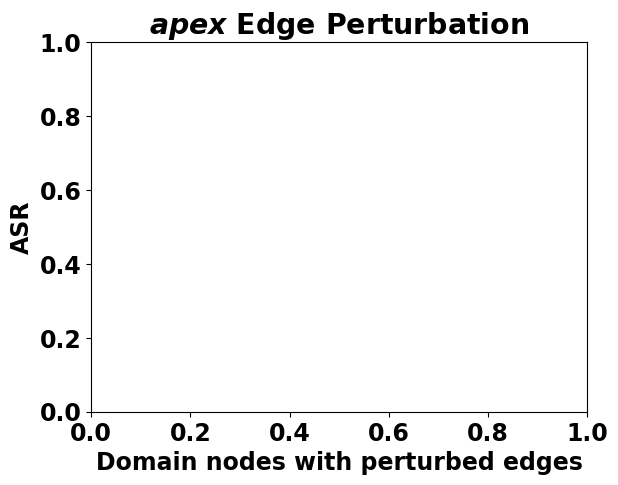

In [18]:
num_change_arr=val_nodes
if not os.path.exists('RESULTS_adj_2_created_doms'):
    os.makedirs('RESULTS_adj_2_created_doms')
plt.figure(facecolor='white')
plt.title("$\it{apex}$ Edge Perturbation")
plt.xlabel("Domain nodes with perturbed edges", weight='bold') 
plt.ylabel("ASR", weight='bold') 
# plot the ASR:
m0, l0, u0=confid_measures(arr1[:,0,:], 100)
plt.plot(val_nodes, m0,'-og', label=("ASR"))
plt.fill_between(num_change_arr, l0, u0, color='green', alpha=0.2)
plt.grid()
plt.fill_between(num_change_arr, l0, u0, color='green', alpha=0.2)
legend_text = 'Mal. doms: %.1f' % (29.57)
plt.legend(loc='lower right', fontsize="11",prop=dict(weight='bold'),title=legend_text)
name='RESULTS_adj_2_created_doms/asr_plot1_'+ str(Num)+'_trials_ras.png'
plt.savefig(name, dpi=150, bbox_inches = 'tight') 
name='RESULTS_adj_2_created_doms/asr_plot1_'+ str(Num)+'_trials_ras.pdf'
plt.savefig(name, dpi=150, bbox_inches = 'tight') 
plt.show()

## Plot NFR

In [ ]:
plt.figure(facecolor='white')
plt.title("$\it{apex}$ Edge Perturbation")
plt.xlabel("Domain nodes with perturbed edges", weight='bold') 
plt.ylabel("NFR", weight='bold') 
m3, l3, u3=confid_measures(arr1[:,3,:], 100)
plt.plot(val_nodes, m3,'-xr', label=("NFR"))
plt.fill_between(num_change_arr, l3, u3, color='red', alpha=0.2)
legend_text = 'Undetected doms: %.1f' % (70.43)
plt.legend(loc='upper left', fontsize="11",prop=dict(weight='bold'),title=legend_text)
plt.grid()
name='RESULTS_adj_2_created_doms/asr_plot3_'+ str(Num)+'_trials_ras.png'
plt.savefig(name, dpi=150, bbox_inches = 'tight') 
name='RESULTS_adj_2_created_doms/asr_plot3_'+ str(Num)+'_trials_ras.pdf'
plt.savefig(name, dpi=150, bbox_inches = 'tight') 
plt.show()

## Plot ROC

In [ ]:
tpr=m0
fpr=m3
plt.figure(facecolor='white')
plt.title("NFR-ASR ROC")
plt.xlabel("NFR", weight='bold') 
plt.ylabel("ASR", weight='bold') 
m3, l3, u3=confid_measures(arr1[:,3,:], 100)
plt.plot(fpr, tpr) 
plt.grid()
name='RESULTS_adj_2_created_doms/ROC_rel_4'+ str(Num)+'.png'
plt.savefig(name, dpi=150, bbox_inches = 'tight') 
name='RESULTS_adj_2_created_doms/ROC_rel_4'+ str(Num)+'.pdf'
plt.savefig(name, dpi=150, bbox_inches = 'tight') 
plt.show()